# Bibliotecas e DataFrame

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

import string
import nltk
from nltk.corpus import stopwords

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, average_precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

filterwarnings('ignore')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guilh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Importando o dataset
df = pd.read_csv('spam_ham_dataset.csv')

# Funções que usaremos

In [3]:
# Função para removermos as pontuações e stopwords de cada email
def process_text(text):
    
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    clean_words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    
    return clean_words

In [4]:
# Função para medir a eficácia de nosso modelo no conjunto de testes
def evaluate(model, X_train, y_train):
    # Definindo nosso metódo de validação cruzada
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    
    # Métricas que iremos usar
    metrics = {
    'Acurácia': accuracy_score,
    'Precisão': precision_score,
    'Recall': recall_score,
    'F1-Score': f1_score,
    'ROC AUC': roc_auc_score
    }
    
    metric_scores = {metric: [] for metric in metrics}
    
    # Construção da validação cruzada
    for index, (index_train, index_test) in enumerate(folds.split(X_train, y_train), start=1):
        print(f'\nFold Número {index}:\n')
        
        X_fold_train, y_fold_train = X_train.iloc[index_train, :], y_train.iloc[index_train]
        X_fold_val, y_fold_val = X_train.iloc[index_test, :], y_train.iloc[index_test]
        
        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_val)
        
        for metric_name, metric_func in metrics.items():
            score = metric_func(y_fold_val, y_pred)
            metric_scores[metric_name].append(score)
            print(f"Fold {index}: {metric_name.capitalize()} - {score:.2%}")
            
    print("\n-----------------\n")
    print("Resultado Médio entre os Folds:\n")
    for metric_name, scores in metric_scores.items():
        mean_score = sum(scores)/len(scores)
        print(f"{metric_name.capitalize()}: {mean_score:.2%}")

In [60]:
# Função que gera uma matriz de correlação
def matrix(model, X_test, y_test):
    
    model.fit(X_train, y_train)
    cm = confusion_matrix(y_test, model.predict(X_test))
    nomes = ['Verdadeiro Neg.','Falso Pos.','Falso Neg.','Verdadeiro Pos.']
    counts = [value for value in cm.flatten()]
    porcentagens = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(nomes, counts, porcentagens)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=labels, cmap='Reds', fmt='')
    plt.show();

# Análise do dataset e algumas melhorias

In [6]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [7]:
df.shape

(5171, 4)

In [8]:
df.isnull().sum()

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

In [9]:
# Retirando colunas que não usaremos
df['text'] = df['text'].str.lstrip('Subject:')
df.drop(['Unnamed: 0', 'label'], axis=1, inplace=True)
df.head()

,text,label_num
0,enron methanol ; meter # : 988291\r\nthis is ...,0
1,"hpl nom for january 9 , 2001\r\n( see attache...",0
2,"neon retreat\r\nho ho ho , we ' re around to ...",0
3,"photoshop , windows , office . cheap . main t...",1
4,re : indian springs\r\nthis deal is to book t...,0


Text(0.5, 1.0, 'Class Counts')

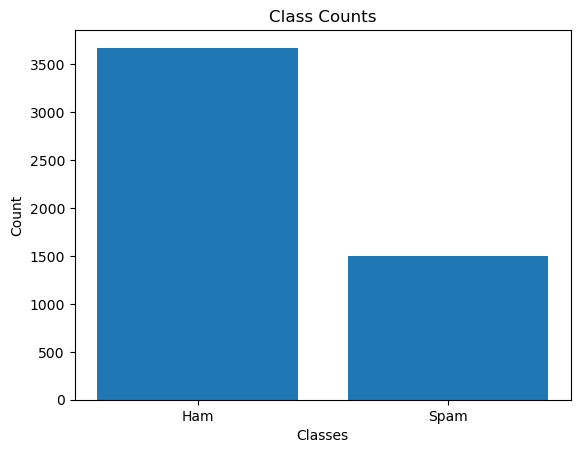

In [10]:
# Verificando a proporcionalidade de nosso target
class_counts = df['label_num'].value_counts()
plt.bar(df['label_num'].value_counts().index, df['label_num'].value_counts().values)

plt.xticks(df['label_num'].value_counts().index, ['Ham', 'Spam'])

plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Counts')

In [11]:
df.duplicated().sum()

178

In [12]:
# Removendo linhas duplicadas
df.drop_duplicates(inplace=True)

In [13]:
df.isnull().sum()

text         0
label_num    0
dtype: int64

In [14]:
# Testando nossa função de remover stopwords e pontuações
df.text.head().apply(process_text)

0    [enron, methanol, meter, 988291, follow, note,...
1    [hpl, nom, january, 9, 2001, see, attached, fi...
2    [neon, retreat, ho, ho, ho, around, wonderful,...
3    [photoshop, windows, office, cheap, main, tren...
4    [indian, springs, deal, book, teco, pvr, reven...
Name: text, dtype: object

# Pré-Processamento

In [15]:
# Passando o conjunto de textos para uma matriz de contagem de palavras
vectorizer = CountVectorizer(analyzer=process_text)
X_values = vectorizer.fit_transform(df.text)
X_values = pd.DataFrame(X_values.toarray(), columns=vectorizer.get_feature_names_out())

In [16]:
X_values.shape

(4993, 50380)

In [18]:
X = X_values
y = df['label_num']
       
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Cross Validation 

In [56]:
# Modelo 1: MultinomialNB
evaluate(MultinomialNB(), X_train, y_train)


Fold Número 1:

Fold 1: Acurácia - 97.50%
Fold 1: Precisão - 94.96%
Fold 1: Recall - 96.58%
Fold 1: F1-score - 95.76%
Fold 1: Roc auc - 97.23%

Fold Número 2:

Fold 2: Acurácia - 97.62%
Fold 2: Precisão - 94.24%
Fold 2: Recall - 97.86%
Fold 2: F1-score - 96.02%
Fold 2: Roc auc - 97.69%

Fold Número 3:

Fold 3: Acurácia - 97.50%
Fold 3: Precisão - 93.85%
Fold 3: Recall - 97.86%
Fold 3: F1-score - 95.82%
Fold 3: Roc auc - 97.60%

Fold Número 4:

Fold 4: Acurácia - 97.87%
Fold 4: Precisão - 96.17%
Fold 4: Recall - 96.58%
Fold 4: F1-score - 96.38%
Fold 4: Roc auc - 97.49%

Fold Número 5:

Fold 5: Acurácia - 99.00%
Fold 5: Precisão - 98.70%
Fold 5: Recall - 97.85%
Fold 5: F1-score - 98.28%
Fold 5: Roc auc - 98.66%

-----------------

Resultado Médio entre os Folds:

Acurácia: 97.90%
Precisão: 95.58%
Recall: 97.35%
F1-score: 96.45%
Roc auc: 97.74%


In [230]:
# Modelo 2: Linear SVC
evaluate(LinearSVC(), X_train, y_train)


Fold Número 1:

Fold 1: Acurácia - 96.12%
Fold 1: Precisão - 92.47%
Fold 1: Recall - 94.44%
Fold 1: F1-score - 93.45%
Fold 1: Roc auc - 95.63%

Fold Número 2:

Fold 2: Acurácia - 95.62%
Fold 2: Precisão - 93.07%
Fold 2: Recall - 91.88%
Fold 2: F1-score - 92.47%
Fold 2: Roc auc - 94.52%

Fold Número 3:

Fold 3: Acurácia - 96.25%
Fold 3: Precisão - 93.59%
Fold 3: Recall - 93.59%
Fold 3: F1-score - 93.59%
Fold 3: Roc auc - 95.47%

Fold Número 4:

Fold 4: Acurácia - 97.37%
Fold 4: Precisão - 93.83%
Fold 4: Recall - 97.44%
Fold 4: F1-score - 95.60%
Fold 4: Roc auc - 97.39%

Fold Número 5:

Fold 5: Acurácia - 96.99%
Fold 5: Precisão - 94.85%
Fold 5: Recall - 94.85%
Fold 5: F1-score - 94.85%
Fold 5: Roc auc - 96.36%

-----------------

Resultado Médio entre os Folds:

Acurácia: 96.47%
Precisão: 93.56%
Recall: 94.44%
F1-score: 93.99%
Roc auc: 95.87%


In [19]:
# Modelo 3: XGBoost Classifier
evaluate(XGBClassifier(), X_train, y_train)


Fold Número 1:

Fold 1: Acurácia - 97.12%
Fold 1: Precisão - 92.03%
Fold 1: Recall - 98.72%
Fold 1: F1-score - 95.26%
Fold 1: Roc auc - 97.59%

Fold Número 2:

Fold 2: Acurácia - 96.87%
Fold 2: Precisão - 92.65%
Fold 2: Recall - 97.01%
Fold 2: F1-score - 94.78%
Fold 2: Roc auc - 96.91%

Fold Número 3:

Fold 3: Acurácia - 96.75%
Fold 3: Precisão - 92.62%
Fold 3: Recall - 96.58%
Fold 3: F1-score - 94.56%
Fold 3: Roc auc - 96.70%

Fold Número 4:

Fold 4: Acurácia - 96.87%
Fold 4: Precisão - 93.00%
Fold 4: Recall - 96.58%
Fold 4: F1-score - 94.76%
Fold 4: Roc auc - 96.79%

Fold Número 5:

Fold 5: Acurácia - 96.74%
Fold 5: Precisão - 92.59%
Fold 5: Recall - 96.57%
Fold 5: F1-score - 94.54%
Fold 5: Roc auc - 96.69%

-----------------

Resultado Médio entre os Folds:

Acurácia: 96.87%
Precisão: 92.58%
Recall: 97.09%
F1-score: 94.78%
Roc auc: 96.93%


In [19]:
# Modelo 4: Random Forest Classifier
evaluate(RandomForestClassifier(), X_train, y_train)


Fold Número 1:

Fold 1: Acurácia - 97.12%
Fold 1: Precisão - 93.78%
Fold 1: Recall - 96.58%
Fold 1: F1-score - 95.16%
Fold 1: Roc auc - 96.96%

Fold Número 2:

Fold 2: Acurácia - 97.00%
Fold 2: Precisão - 93.39%
Fold 2: Recall - 96.58%
Fold 2: F1-score - 94.96%
Fold 2: Roc auc - 96.87%

Fold Número 3:

Fold 3: Acurácia - 97.00%
Fold 3: Precisão - 92.68%
Fold 3: Recall - 97.44%
Fold 3: F1-score - 95.00%
Fold 3: Roc auc - 97.13%

Fold Número 4:

Fold 4: Acurácia - 97.62%
Fold 4: Precisão - 93.52%
Fold 4: Recall - 98.72%
Fold 4: F1-score - 96.05%
Fold 4: Roc auc - 97.94%

Fold Número 5:

Fold 5: Acurácia - 97.99%
Fold 5: Precisão - 95.40%
Fold 5: Recall - 97.85%
Fold 5: F1-score - 96.61%
Fold 5: Roc auc - 97.95%

-----------------

Resultado Médio entre os Folds:

Acurácia: 97.35%
Precisão: 93.75%
Recall: 97.43%
F1-score: 95.56%
Roc auc: 97.37%


In [24]:
# Modelo 5: Logistic Regression
evaluate(LogisticRegression(solver='liblinear'), X_train, y_train)


Fold Número 1:

Fold 1: Acurácia - 97.75%
Fold 1: Precisão - 94.63%
Fold 1: Recall - 97.86%
Fold 1: F1-score - 96.22%
Fold 1: Roc auc - 97.78%

Fold Número 2:

Fold 2: Acurácia - 97.87%
Fold 2: Precisão - 95.40%
Fold 2: Recall - 97.44%
Fold 2: F1-score - 96.41%
Fold 2: Roc auc - 97.74%

Fold Número 3:

Fold 3: Acurácia - 97.50%
Fold 3: Precisão - 94.21%
Fold 3: Recall - 97.44%
Fold 3: F1-score - 95.80%
Fold 3: Roc auc - 97.48%

Fold Número 4:

Fold 4: Acurácia - 97.75%
Fold 4: Precisão - 93.90%
Fold 4: Recall - 98.72%
Fold 4: F1-score - 96.25%
Fold 4: Roc auc - 98.03%

Fold Número 5:

Fold 5: Acurácia - 98.12%
Fold 5: Precisão - 96.19%
Fold 5: Recall - 97.42%
Fold 5: F1-score - 96.80%
Fold 5: Roc auc - 97.92%

-----------------

Resultado Médio entre os Folds:

Acurácia: 97.80%
Precisão: 94.87%
Recall: 97.78%
F1-score: 96.29%
Roc auc: 97.79%


In [25]:
acuracia_scores = [97.90, 96.47, 96.87, 97.35, 97.80]
f1_scores = [96.45, 93.99, 94.78, 95.56, 96.29]
roc_scores = [97.74, 97.74, 96.93, 97.37, 97.79]
modelos = ['MultinomialNB', 'Linear SVC', 'XGBoost Classifier', 'Random Forest Classifier', 'Logistic Regression']

Text(0, 0.5, 'ROC AUC')

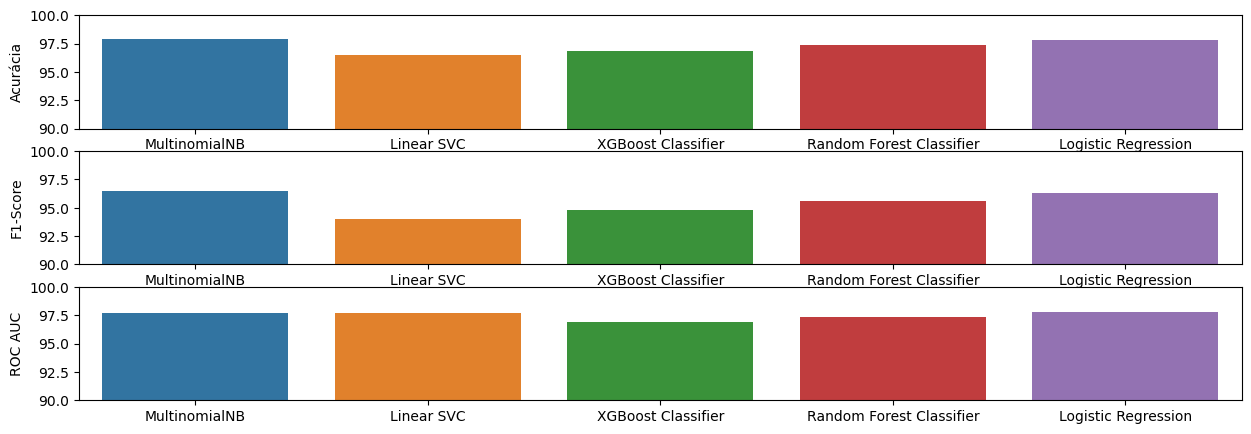

In [45]:
fig, ax = plt.subplots(3, 1, figsize = (15, 5))

sns.barplot(x=modelos, y=acuracia_scores, ax=ax[0])
ax[0].set_ylim(90, 100)
ax[0].set_ylabel('Acurácia')
sns.barplot(x=modelos, y=f1_scores, ax=ax[1])
ax[1].set_ylim(90, 100)
ax[1].set_ylabel('F1-Score')
sns.barplot(x=modelos, y=roc_scores, ax=ax[2])
ax[2].set_ylim(90, 100)
ax[2].set_ylabel('ROC AUC')

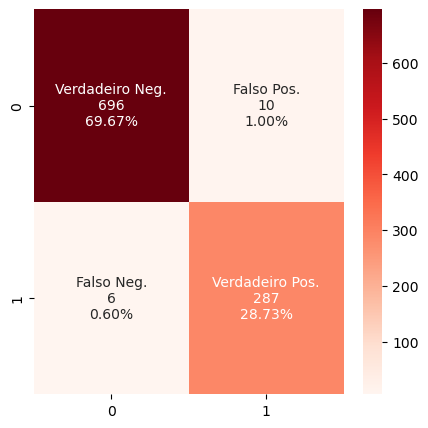

In [61]:
matrix(MultinomialNB(), X_test, y_test)

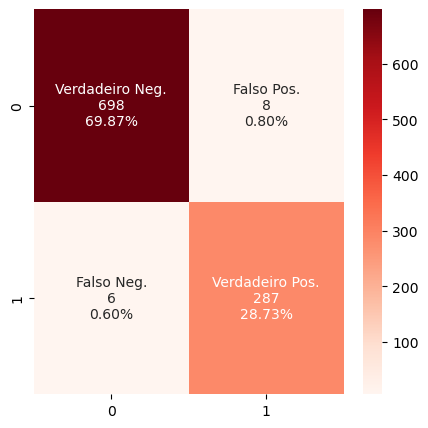

In [63]:
matrix(LogisticRegression(solver='liblinear'), X_test, y_test)

# Resultado Final

Como podemos observar nas matrizes acima, o modelo de Regressão Logística apresentou uma incidência menor de Falsos Positivos em comparação com o modelo MultinomialNB. Considerando a relevância desse aspecto para a detecção de emails de spam, a nossa escolha para o modelo final recai sobre a Regressão Logística.

Neste projeto de aprendizado de máquina, nosso objetivo era desenvolver um sistema eficaz para a detecção de emails de spam. Após a avaliação de diferentes modelos, métricas e técnicas, conseguimos criar um modelo baseado em Regressão Logística que se destacou. Ele apresentou um desempenho notável, com apenas 8 casos de Falsos Positivos, ou seja, situações em que emails legítimos foram erroneamente classificados como spam. Esse resultado demonstra a robustez do nosso modelo na minimização de interrupções desnecessárias para os usuários, ao mesmo tempo em que mantém uma taxa de detecção eficaz de emails de spam.